In [218]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Random
using Knet: Knet, conv4, pool, mat, adam,KnetArray, momentum,nll, zeroone,save, load ,progress, sgd, param, param0, dropout, relu, Data,gpu,minibatch

In [219]:
import Knet.load
import Knet.save
import AutoGrad

In [220]:
Pkg.status()

    Status `~/.julia/environments/v1.1/Project.toml`
  [6710c13c] AutoGrad v1.1.3
  [944b1d66] CodecZlib v0.5.2
  [5ae59095] Colors v0.9.5
  [5789e2e9] FileIO v1.0.6
  [7073ff75] IJulia v1.18.0
  [6218d12a] ImageMagick v0.7.1
  [916415d5] Images v0.17.3
  [033835bb] JLD2 v0.1.2
  [682c06a0] JSON v0.20.0
  [1902f260] Knet v1.2.1
  [ae8d54c2] Luxor v1.2.0
  [23992714] MAT v0.5.0
  [91a5bcdd] Plots v0.24.0
  [438e738f] PyCall v1.91.1
  [5e47fb64] TestImages v0.5.0


In [221]:
cd()
cd("/media/mvgl/DATAONE/Tugce")
dtst=Knet.load("dtest8t.jld2","m")
dtrn=Knet.load("dtsty8t.jld2","m")

Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}([0.788235 0.415686 … 0.796078 0.537255; 0.788235 0.415686 … 0.8 0.545098; … ; 0.290196 0.231373 … 0.439216 0.556863; 0.294118 0.231373 … 0.45098 0.556863], [4 2 … 3 4], 30, 1260, false, 1231, 1:1260, false, (224, 224, 3, 30), (1260,), KnetArray{Float32,N} where N, Array{UInt8,1})

In [222]:
a=collect(dtst);

In [223]:
summary(a[1])

"Tuple{KnetArray{Float32,4},Array{UInt8,1}}"

In [224]:
yy=[]
for k=1:6
yy=cat(yy,convert(Array{Int8,1},a[k][2]);dims=1)
end
yy

180-element Array{Any,1}:
 4
 6
 2
 1
 1
 6
 3
 4
 5
 4
 5
 2
 1
 ⋮
 1
 5
 1
 3
 5
 1
 5
 6
 4
 1
 1
 3

In [225]:
cd()
cd("/media/mvgl/DATAONE/Tugce")
Knet.save("confy8t.jld2","m",yy)

In [226]:
# For running experiments
function trainresults(file,model; o...)
   
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,50);lr=1e-5))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [227]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [228]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [229]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv0(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv0

In [230]:
# Define a convolutional layer:
struct Conv01; w; b; f; p; end
(c::Conv01)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv01(w ,b,f=relu;pdrop=0) = Conv01(w ,b, f, pdrop)

Conv01

In [231]:
# Define a convolutional layer:
struct Conv1; w; b; f; p; end
(c::Conv1)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,padding=1,stride=2))
Conv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv1(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)


Conv1

In [232]:
# Define a convolutional layer:
struct Conv11; w; b; f; p; end
(c::Conv11)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,padding=1,stride=2))
Conv11(w ,b,f=relu;pdrop=0) = Conv11(w ,b, f, pdrop)


Conv11

In [233]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [234]:
cd()
cd(readdir, "/media/mvgl/DATAONE/Tugce")

118-element Array{String,1}:
 "cnn2.jld2"         
 "conf"              
 "confnn"            
 "conft"             
 "confy1t.jld2"      
 "confy2t.jld2"      
 "confy3t.jld2"      
 "confy4t.jld2"      
 "confy5t.jld2"      
 "confy6t.jld2"      
 "confy7t.jld2"      
 "confy8t.jld2"      
 "confyp1t.jld2"     
 ⋮                   
 "lenet1loss5.jld2"  
 "lenet1loss5nn.jld2"
 "lenet1loss5t.jld2" 
 "lenet1loss6.jld2"  
 "lenet1loss6nn.jld2"
 "lenet1loss6t.jld2" 
 "lenet1loss7.jld2"  
 "lenet1loss7nn.jld2"
 "lenet1loss7t.jld2" 
 "lenet1loss8.jld2"  
 "lenet1loss8nn.jld2"
 "lenet1loss8t.jld2" 

In [235]:
cd("/media/mvgl/DATAONE/Tugce")
CC=Knet.load("lenet1loss8t.jld2","b")

Chain((Conv0(P(KnetArray{Float32,4}(3,3,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), Knet.relu, 0), Conv0(P(KnetArray{Float32,4}(3,3,64,128)), P(KnetArray{Float32,4}(1,1,128,1)), Knet.relu, 0), Conv0(P(KnetArray{Float32,4}(3,3,128,256)), P(KnetArray{Float32,4}(1,1,256,1)), Knet.relu, 0), Conv0(P(KnetArray{Float32,4}(3,3,256,256)), P(KnetArray{Float32,4}(1,1,256,1)), Knet.relu, 0), Conv1(P(KnetArray{Float32,4}(3,3,256,512)), P(KnetArray{Float32,4}(1,1,512,1)), Knet.relu, 0)))

In [236]:
CC.layers[1].w.opt=nothing
CC.layers[2].w.opt=nothing
CC.layers[3].w.opt=nothing
CC.layers[4].w.opt=nothing
CC.layers[5].w.opt=nothing

In [237]:
CC.layers[1].b.opt=nothing
CC.layers[2].b.opt=nothing
CC.layers[3].b.opt=nothing
CC.layers[4].b.opt=nothing
CC.layers[5].b.opt=nothing

In [238]:
lenet2 =   Chain(Conv01(CC.layers[1].w,CC.layers[1].b),
                 Conv01(CC.layers[2].w,CC.layers[2].b),
                 Conv01(CC.layers[3].w,CC.layers[3].b),
                Conv01(CC.layers[4].w,CC.layers[4].b),
                Conv11(CC.layers[5].w,CC.layers[5].b),
                 Dense(7*7*512,256,pdrop=0.5),
                    Dense(256,6,identity))
summary.(l.w for l in lenet2.layers)

7-element Array{String,1}:
 "3×3×3×64 AutoGrad.Param{KnetArray{Float32,4}}"   
 "3×3×64×128 AutoGrad.Param{KnetArray{Float32,4}}" 
 "3×3×128×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×512 AutoGrad.Param{KnetArray{Float32,4}}"
 "256×25088 AutoGrad.Param{KnetArray{Float32,2}}"  
 "6×256 AutoGrad.Param{KnetArray{Float32,2}}"      

In [239]:
cnn = trainresults("cnn2.jld2", lenet2);

4.30e-02  100.00%┣█████████████████████┫ 2100/2100 [05:48/05:48, 6.03i/s]
Float32[0.000345499; 0.224932; 0.0; 0.0722222]


In [240]:
using Plots; default(fmt=:png,ls=:auto)

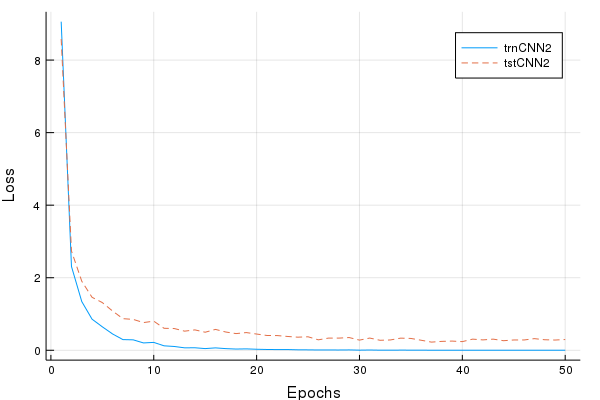

In [241]:
plot([cnn[1,:], cnn[2,:]],
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

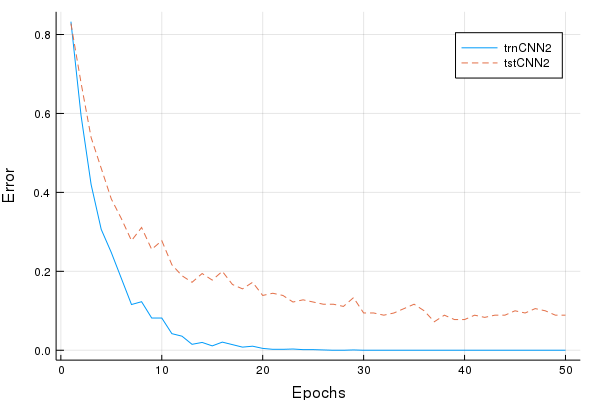

In [242]:
plot([cnn[3,:], cnn[4,:]],
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Error")

In [243]:
y=[]
y=convert(Array{Float32},lenet2(a[1][1]))
for k=2:6
    y=hcat(y,convert(Array{Float32},lenet2(a[k][1])))
end
y

6×150 Array{Float32,2}:
 -5.14258   -14.3903   -6.46931  …  -6.68283     4.7371   -3.29274
 -4.38065   -15.9031    2.49685     -0.934322   -4.03294   5.73268
 -0.853384    4.19059  -3.13522      7.16821    -5.09144  -4.48177
  8.11839    -7.33049  -3.97548     -2.9729    -11.302    -7.49459
 -4.94258    -5.22292  -5.31606     -7.39468    -4.84318  -4.86866
 -8.83879    13.979    -8.27842  …  -2.94932    -8.58726  -8.37081

In [244]:
zeroone(lenet2,dtst)

0.07777777777777772

In [245]:
zeroone(lenet2,dtrn)

0.0

In [246]:
cd()
cd("/media/mvgl/DATAONE/Tugce")
Knet.save("confyp8t.jld2","m",y)

In [247]:
cd(readdir,"/media/mvgl/DATAONE/Tugce")

119-element Array{String,1}:
 "cnn2.jld2"         
 "conf"              
 "confnn"            
 "conft"             
 "confy1t.jld2"      
 "confy2t.jld2"      
 "confy3t.jld2"      
 "confy4t.jld2"      
 "confy5t.jld2"      
 "confy6t.jld2"      
 "confy7t.jld2"      
 "confy8t.jld2"      
 "confyp1t.jld2"     
 ⋮                   
 "lenet1loss5.jld2"  
 "lenet1loss5nn.jld2"
 "lenet1loss5t.jld2" 
 "lenet1loss6.jld2"  
 "lenet1loss6nn.jld2"
 "lenet1loss6t.jld2" 
 "lenet1loss7.jld2"  
 "lenet1loss7nn.jld2"
 "lenet1loss7t.jld2" 
 "lenet1loss8.jld2"  
 "lenet1loss8nn.jld2"
 "lenet1loss8t.jld2" 